In [13]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [14]:
data_path = "/kaggle/input/cassava-leaf-disease-classification"
train_data_path = os.path.join(data_path, "train.csv")
train_img_path = os.path.join(data_path, 'train_images')
train = pd.read_csv(train_data_path)

In [15]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


train num: 21397
label num:
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


<Axes: >

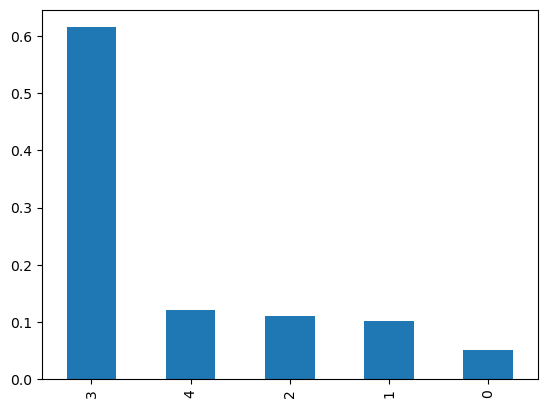

In [16]:
# EDA
print("train num: {}".format(len(train)))
print("label num:")
print(train['label'].value_counts()/len(train))
(train['label'].value_counts()/len(train)).plot(kind="bar")

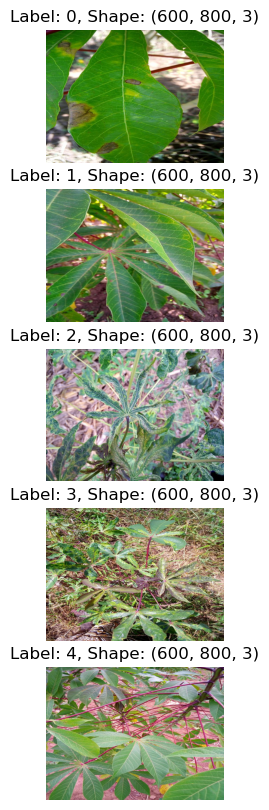

In [17]:
def show_imgs(df:pd.DataFrame, figsize=(12,10)):
    fig = plt.figure(figsize=figsize)
    label_num = len(df['label'].unique())
    
    for i in range(label_num):
        sample = df[df["label"]==i]['image_id'].sample().reset_index(drop=True).iloc[0]
        sample = os.path.join(train_img_path, sample)
        img = cv2.imread(sample)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = fig.add_subplot(5, 1, i+1)
        plt.imshow(img)
        plt.title("Label: {}, Shape: {}".format(i, img.shape))
        plt.axis("off")
        
plt.show()

show_imgs(train)

In [18]:
# check label
with open("/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json") as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k):v for k, v in name_mapping.items()}
train["class_id"] = train['label'].map(name_mapping)
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

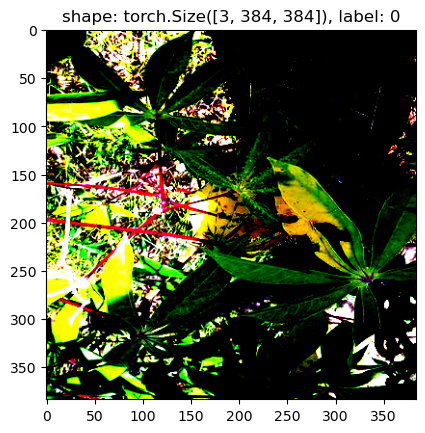

In [19]:
# create Dataset and Transform
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, data_path:str, phase:str='train', transform:object=None):
        self.df = df
        self.data_path = train_img_path
        self.phase = phase
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sample = self.df['image_id'].iloc[idx]
        img = cv2.imread(os.path.join(self.data_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(self.phase, img)
        
        if self.phase == 'test':
            return img
        
        label = self.df['label'].iloc[idx]
        
        return img, label
        
class Transform(object):
    def __init__(self, resize, mean, std):
        self.transform = {
            'train':A.Compose([
                A.RandomResizedCrop(height=resize, width=resize, p=1.0),
                A.VerticalFlip(),
                A.HorizontalFlip(),
                A.ShiftScaleRotate(),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'val':A.Compose([
                A.CenterCrop(height=resize, width=resize, p=1.0),
                A.Normalize(std, mean),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.CenterCrop(height=resize, width=resize, p=1.0),
                A.Normalize(std, mean),
                ToTensorV2()
            ])
        }
    
    def __call__(self, phase, img):
        return self.transform[phase](image=img)['image']
    
# check dataset
crop_size = 384
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = Transform(crop_size, mean, std)
train_dataset = CassavaDataset(train, train_img_path, 'train', transform=transform)
img, label = train_dataset.__getitem__(0)

plt.imshow(img.squeeze().numpy().transpose(1,2,0))
plt.title("shape: {}, label: {}".format(img.size(), label))
plt.show()


In [20]:
import torchvision
from torchvision.models import vit_b_16

model = vit_b_16(torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
model

KeyboardInterrupt: 

In [ ]:
import time
from tqdm.notebook import tqdm

model.heads[0] = nn.Linear(768, 5, bias=True)

def train_model(model, dl_dict, epochs, criterion, optimizer, device, scheduler):
    best_acc = 0
    since = time.time()
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.is_benchmark = True
    
    for epoch in range(1, epochs+1):
        print("{}/{}".format(epoch, epochs+1))
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dl_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                
            epoch_loss = running_loss / len(dl_dict[phase].dataset)
            epoch_acc = running_corrects / len(dl_dict[phase].dataset)
            
            if scheduler != None and phase == 'train':
                scheduler.step(epoch_loss)
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_ViT.pth')
            
            print("{} Loss:{:4f}, Acc:{:4f}".format(phase, epoch_loss, epoch_acc))
        print()
        
    time_elapced = time.time() - since
    print("Training Complete: {}m {}s".format(time_elapced//60, time_elapced%60))
    print("best acc: {:4f}".format(best_acc))
    
train, val = train_test_split(train, test_size=0.2, random_state=0, stratify=train['label'])
traindataset = CassavaDataset(train, train_img_path, 'train', transform)
valdataset = CassavaDataset(val, train_img_path, 'val', transform)
train_dl = DataLoader(traindataset, batch_size=16, shuffle=True, num_workers=2)
val_dl = DataLoader(valdataset, batch_size=16, shuffle=False, num_workers=2)
dl_dict = {'train':train_dl, 'val':val_dl}

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)
criterion = nn.CrossEntropyLoss()
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, dl_dict, epochs, criterion, optimizer, device, scheduler)

1/6
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss:18.246621, Acc:9.852337


  0%|          | 0/268 [00:00<?, ?it/s]

val Loss:21.103202, Acc:9.361940

2/6
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

In [ ]:
# model prepareration
model.load_state_dict(model.load(os.path.join(data_path, 'baseline-visiontransformer/best_ViT.pth')))
model = model.to(device)
model.eval()

In [ ]:
# test
test_path = os.path.join(data_path, 'sample_submission.csv')
test_img_path = os.path.join(data_path, 'test_images')
test = pd.read_csv(test_path)

test_dataset = CassavaDataset(test, test_img_path, 'test', transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=2, shuffle=False)

preds = []

for inputs in test_dataloader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    preds.append(pred)
    
test['label'] = np.concatenate(preds)
test.to_csv('submission.csv')